- https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/plan-and-execute/plan-and-execute.ipynb
    - 更侧重任务规划（tasks planning，及管理）与执行 (tool use/function calling, execute)；
        -  multi-step plan, plan means steps, 而非单步；
    - https://arxiv.org/abs/2305.04091
    - https://github.com/yoheinakajima/babyagi
    - vs. ReAct (you think one step at a time，缺乏 high level 的 plan)
        - Explicit long term planning (which even really strong LLMs can struggle with)
        - Ability to use smaller/weaker models for the execution step, only using larger/better models for the planning step
            - heterogeneous
    - Plan-And-Execute：each task is still executed in sequence,
- LangGraph
    - 全局共享的 state，相当于所有节点的 working memory
    - 将每个 node 理解为 agent，langgraph 的 graph 实例相当于定义了 agents 的组织运转方式，非常方便地构建 multi-agents 系统；

In [1]:
from dotenv import load_dotenv
assert load_dotenv()

### tools & execution agent

- create_react_agent:
    - cycle 
    - two nodes
        - agent (llm) 不再产生 tool call 的请求为止；
            - `not isinstance(last_message, AIMessage) or not last_message.tool_calls:`
        - tools:
            - `ToolNode()`：function executed
    - base messages
        - HumanMessage (from user query/request)
        - AIMessage (generated by `agent` node)
            - `tool_calls`：构造要调用的函数及其入参；
        - ToolMessage (generated by `tools` node)
            - 函数执行的结果；
        - AIMessage

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [3]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
# https://smith.langchain.com/hub/ih/ih-react-agent-executor
prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


In [4]:
from rich.pretty import pprint
pprint(prompt)

ChatPromptTemplate(
│   input_variables=['messages'],
│   input_types={
│   │   'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.messages.function.FunctionMessageChunk, Tag(tag='FunctionMessageChunk')], typing.Annotated[langchain_core.messages.tool.ToolMessageChunk, Tag(tag='ToolMessageChunk')]], FieldInfo(annotation=NoneType, required=True, discriminator=Discriminator(discriminator=<function _get_type at 0x796e88d28a40>, custom_error_type=None, custom_error_message=None, custom_error_context=None))]]
│   },
│   partial_variables={},
│   metadata={
│   │   'lc_hub_owner': 'ih',
│   │   'lc_hub_repo': 'ih-react-agent-executor',
│   │   'lc_hub_commit_hash': '2a7f3083c7d6d9e656c8bb77567347c248f45c109c38f9104a1167f7cf113b87'
│   },
│   messages=[
│   │   SystemMessagePromptTemplate(
│   │   │   prompt=PromptTemplate(
│   │   │   │   input_variables=[],
│   │   │   │   input_types={},
│   │   │   │   partial_variables={},
│   │   │   │   template='You are a helpful assistant.'
│   │   │   ),
│   │   │   additional_kwargs={}
│   │   ),
│   │   MessagesPlaceholder(variable_name='messages')
│   ]
)

In [5]:
# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

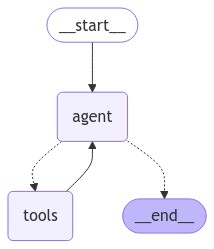

In [6]:
from IPython.display import Image, display

try:
    display(Image(agent_executor.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [7]:
resp = agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

In [8]:
pprint(resp)

{
│   'messages': [
│   │   HumanMessage(
│   │   │   content='who is the winnner of the us open',
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   id='60ea152f-a76a-4932-8db1-1df22585b664'
│   │   ),
│   │   AIMessage(
│   │   │   content='The term "US Open" could refer to either the US Open Tennis Championships or the US Open Golf Championship. Could you please specify which one you are referring to?',
│   │   │   additional_kwargs={'refusal': None},
│   │   │   response_metadata={
│   │   │   │   'token_usage': {
│   │   │   │   │   'completion_tokens': 34,
│   │   │   │   │   'prompt_tokens': 95,
│   │   │   │   │   'total_tokens': 129,
│   │   │   │   │   'prompt_tokens_details': {'cached_tokens': 0},
│   │   │   │   │   'completion_tokens_details': {'reasoning_tokens': 0}
│   │   │   │   },
│   │   │   │   'model_name': 'gpt-4o-2024-08-06',
│   │   │   │   'system_fingerprint': 'fp_90354628f2',
│   │   │   │   'finish_reason': 'stop',
│   │   │   │   'logprobs': None
│   │   │   },
│   │   │   id='run-439ffda6-4330-425b-95a0-c25d1c89e151-0',
│   │   │   usage_metadata={'input_tokens': 95, 'output_tokens': 34, 'total_tokens': 129}
│   │   )
│   ]
}

In [9]:
from langchain_core.messages import HumanMessage
resp = agent_executor.invoke({"messages": [
    HumanMessage("who is the winnner of the us open")
]})

In [10]:
pprint(resp)

{
│   'messages': [
│   │   HumanMessage(
│   │   │   content='who is the winnner of the us open',
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   id='0c92c478-a8b2-4ce4-901a-1e4d55647f1e'
│   │   ),
│   │   AIMessage(
│   │   │   content="Could you specify which US Open you're referring to? There are multiple US Open tournaments, including those for tennis and golf. If you could clarify whether you mean the US Open in tennis, the US Open in golf, or any other specific event, that would be helpful.",
│   │   │   additional_kwargs={'refusal': None},
│   │   │   response_metadata={
│   │   │   │   'token_usage': {
│   │   │   │   │   'completion_tokens': 55,
│   │   │   │   │   'prompt_tokens': 95,
│   │   │   │   │   'total_tokens': 150,
│   │   │   │   │   'prompt_tokens_details': {'cached_tokens': 0},
│   │   │   │   │   'completion_tokens_details': {'reasoning_tokens': 0}
│   │   │   │   },
│   │   │   │   'model_name': 'gpt-4o-2024-08-06',
│   │   │   │   'system_fingerprint': 'fp_9e15ccd6a4',
│   │   │   │   'finish_reason': 'stop',
│   │   │   │   'logprobs': None
│   │   │   },
│   │   │   id='run-73adc204-4dd2-468f-ab14-98ca26bd733d-0',
│   │   │   usage_metadata={'input_tokens': 95, 'output_tokens': 55, 'total_tokens': 150}
│   │   )
│   ]
}

In [11]:
from langchain_core.messages import HumanMessage
resp = agent_executor.invoke({"messages": [
    HumanMessage("2024年诺贝尔物理学奖颁给了谁")
]})

In [12]:
pprint(resp)

{
│   'messages': [
│   │   HumanMessage(
│   │   │   content='2024年诺贝尔物理学奖颁给了谁',
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   id='3eedfdc9-9943-4516-93ea-fa43444a969a'
│   │   ),
│   │   AIMessage(
│   │   │   content='',
│   │   │   additional_kwargs={
│   │   │   │   'tool_calls': [
│   │   │   │   │   {
│   │   │   │   │   │   'id': 'call_urc6DQHRmio86CZ2y9q5Qe0L',
│   │   │   │   │   │   'function': {
│   │   │   │   │   │   │   'arguments': '{"query":"2024 Nobel Prize in Physics winner"}',
│   │   │   │   │   │   │   'name': 'tavily_search_results_json'
│   │   │   │   │   │   },
│   │   │   │   │   │   'type': 'function'
│   │   │   │   │   }
│   │   │   │   ],
│   │   │   │   'refusal': None
│   │   │   },
│   │   │   response_metadata={
│   │   │   │   'token_usage': {
│   │   │   │   │   'completion_tokens': 24,
│   │   │   │   │   'prompt_tokens': 100,
│   │   │   │   │   'total_tokens': 124,
│   │   │   │   │   'prompt_tokens_details': {'cached_tokens': 0},
│   │   │   │   │   'completion_tokens_details': {'reasoning_tokens': 0}
│   │   │   │   },
│   │   │   │   'model_name': 'gpt-4o-2024-08-06',
│   │   │   │   'system_fingerprint': 'fp_90354628f2',
│   │   │   │   'finish_reason': 'tool_calls',
│   │   │   │   'logprobs': None
│   │   │   },
│   │   │   id='run-52fab91b-ce19-4363-b8c9-58cfd1b24235-0',
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'tavily_search_results_json',
│   │   │   │   │   'args': {'query': '2024 Nobel Prize in Physics winner'},
│   │   │   │   │   'id': 'call_urc6DQHRmio86CZ2y9q5Qe0L',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ],
│   │   │   usage_metadata={'input_tokens': 100, 'output_tokens': 24, 'total_tokens': 124}
│   │   ),
│   │   ToolMessage(
│   │   │   content='[{"url": "https://www.cnn.com/2024/10/08/science/nobel-prize-physics-hopfield-hinton-machine-learning-intl/index.html", "content": "Nobel Prize in physics 2024 awarded for work on artificial intelligence to John Hopfield and Geoffrey Hinton | CNN CNN10 About CNN The 2024 Nobel Prize in physics has been awarded to John Hopfield and Geoffrey Hinton for their fundamental discoveries in machine learning, which paved the way for how artificial intelligence is used today. “Their work was fundamental in laying the cornerstones for what we experience today as artificial intelligence,” Mark Pearce, a member of the Nobel committee of physics, told CNN. Michael Moloney, chief executive of the American Institute of Physics, told CNN that the Nobel Prize winners’ work had transformed science, allowing machine learning systems to process huge amounts of data and allow scientists to spot patterns they would not otherwise be able to see."}, {"url": "https://www.ap.org/news-highlights/spotlights/2024/pioneers-in-artificial-intelligence-win-the-nobel-prize-in-physics/", "content": "This photo combo shows the 2024 Nobel Prize winners in Physics, professor John Hopfield, left, of Princeton University, and professor Geoffrey Hinton, of the University of Toronto, Tuesday, Oct. 8, 2024. STOCKHOLM (AP) — Two pioneers of artificial intelligence — John Hopfield and Geoffrey Hinton — won the Nobel Prize in physics Tuesday for helping create the building blocks of machine learning that is revolutionizing the way we work and live but also creates new threats for humanity. This photo combo shows the 2024 Nobel Prize winners in Physics, professor John Hopfield, left, of Princeton University, and professor Geoffrey Hinton, of the University of Toronto, Tuesday, Oct. 8, 2024."}, {"url": "https://www.nobelprize.org/prizes/physics/2024/press-release/", "content": "Press release: The Nobel Prize in Physics 2024 - NobelPrize.org Nobel Prizes & laureates All Nobel Prizes All Nobel Prizes 2024 Physics prize About the prize The Nobel Prize in Physics 2024 The Royal Swedish Academy of Sciences has decided to award the Nobel Prize in Physics 2024 to This year’s two Nobel Laure

In [13]:
resp['messages'][-1].tool_calls

[]

### define the graph

#### Define the (global share) State

In [14]:
import operator
from typing import Annotated, List, Tuple, TypedDict

class PlanExecute(TypedDict):
    query: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

#### planning steps

In [15]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [17]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

In [19]:
pprint(planner_prompt)

ChatPromptTemplate(
│   input_variables=[],
│   optional_variables=['messages'],
│   input_types={
│   │   'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.messages.function.FunctionMessageChunk, Tag(tag='FunctionMessageChunk')], typing.Annotated[langchain_core.messages.tool.ToolMessageChunk, Tag(tag='ToolMessageChunk')]], FieldInfo(annotation=NoneType, required=True, discriminator=Discriminator(discriminator=<function _get_type at 0x796e88d28a40>, custom_error_type=None, custom_error_message=None, custom_error_context=None))]]
│   },
│   partial_variables={'messages': []},
│   messages=[
│   │   SystemMessagePromptTemplate(
│   │   │   prompt=PromptTemplate(
│   │   │   │   input_variables=[],
│   │   │   │   input_types={},
│   │   │   │   partial_variables={},
│   │   │   │   template='For the given objective, come up with a simple step by step plan. This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.'
│   │   │   ),
│   │   │   additional_kwargs={}
│   │   ),
│   │   MessagesPlaceholder(variable_name='messages', optional=True)
│   ]
)

In [38]:
print(planner_prompt.messages[0].prompt.template)

For the given objective, come up with a simple step by step plan. This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.


In [21]:
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-2024-08-06", temperature=0
).with_structured_output(Plan)

In [22]:
response = planner.invoke({
    "messages": [
        ("user", "what is the hometown of the current Australia open winner?")
    ]
})

In [24]:
pprint(response)

Plan(
│   steps=[
│   │   'Identify the current year.',
│   │   'Determine the winner of the Australian Open for the current year.',
│   │   'Research the hometown of the identified winner.',
│   │   'Provide the hometown as the final answer.'
│   ]
)

#### Re-Plan Step

- Now, let's create a step that re-does the plan based on the result of the previous step.

In [27]:
from typing import Union

class Response(BaseModel):
    """Response to user."""
    response: str

class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [50]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{query}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

In [51]:
pprint(replanner_prompt)

ChatPromptTemplate(
│   input_variables=['past_steps', 'plan', 'query'],
│   input_types={},
│   partial_variables={},
│   messages=[
│   │   HumanMessagePromptTemplate(
│   │   │   prompt=PromptTemplate(
│   │   │   │   input_variables=['past_steps', 'plan', 'query'],
│   │   │   │   input_types={},
│   │   │   │   partial_variables={},
│   │   │   │   template='For the given objective, come up with a simple step by step plan. This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.\n\nYour objective was this:\n{query}\n\nYour original plan was this:\n{plan}\n\nYou have currently done the follow steps:\n{past_steps}\n\nUpdate your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.'
│   │   │   ),
│   │   │   additional_kwargs={}
│   │   )
│   ]
)

In [52]:
print(replanner_prompt.messages[0].prompt.template)

For the given objective, come up with a simple step by step plan. This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{query}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.


In [53]:
replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-2024-08-06", temperature=0
).with_structured_output(Act)

#### Create the Graph

In [40]:
from typing import Literal
from langgraph.graph import END

In [43]:
from typing import get_type_hints
get_type_hints(PlanExecute)

{'query': str,
 'plan': typing.List[str],
 'past_steps': typing.List[typing.Tuple],
 'response': str}

In [44]:
async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["query"])]})
    return {"plan": plan.steps}
    
async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    # 追加
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

async def replan_step(state: PlanExecute):
    # replanner => Act (Response, or, Plan) 
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [54]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

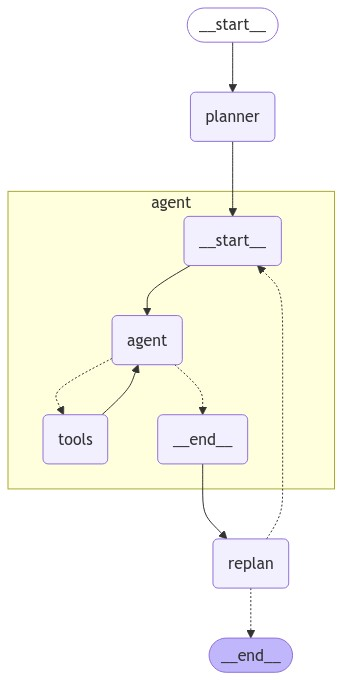

In [55]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [57]:
config = {"recursion_limit": 50}
inputs = {"query": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the winner of the men's 2024 Australian Open.", "Research the winner's personal background to find their hometown.", 'Verify the information from a reliable source to ensure accuracy.', 'Conclude with the hometown of the winner.']}
{'past_steps': [("Identify the winner of the men's 2024 Australian Open.", "The winner of the men's 2024 Australian Open is Jannik Sinner.")]}
{'plan': ["Research Jannik Sinner's personal background to find his hometown.", 'Verify the information from a reliable source to ensure accuracy.', 'Conclude with the hometown of Jannik Sinner.']}
{'past_steps': [("Research Jannik Sinner's personal background to find his hometown.", "Jannik Sinner's hometown is Sexten, also known as Sesto Pusteria, located in the Dolomites region of northern Italy.")]}
{'response': "The hometown of the men's 2024 Australian Open winner, Jannik Sinner, is Sexten, also known as Sesto Pusteria, located in the Dolomites region of northern Italy."}
